In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from IPython.display import display, Markdown

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_labels, test_labels = to_categorical(train_labels), to_categorical(test_labels)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
def create_models():
    models_dict = {}

    models_dict['No Norm'] = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    models_dict['BatchNorm'] = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(10, activation='softmax')
    ])

    models_dict['LayerNorm'] = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.LayerNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.LayerNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.LayerNormalization(),
        layers.Dense(10, activation='softmax')
    ])

    models_dict['Dropout'] = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    return models_dict

In [ ]:
def train_models(models_dict, epochs=10, batch_size=64):
    results = {}
    for name, model in tqdm(models_dict.items(), desc="Training models"):
        model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

        start_time = time.time()
        history = model.fit(train_images, train_labels,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=(test_images, test_labels),
                          verbose=0)
        training_time = time.time() - start_time

        results[name] = {
            'model': model,
            'history': history,
            'time': training_time,
            'params': model.count_params()
        }
    return results

In [ ]:
norm_models = create_models()
norm_results = train_models(norm_models)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training models: 100%|██████████| 4/4 [03:20<00:00, 50.16s/it]


In [ ]:
def create_architectures():
    architectures = {}

    # ResNet50
    architectures['ResNet50'] = tf.keras.applications.ResNet50(
        weights=None,
        input_shape=(32, 32, 3),
        include_top=True,
        classes=10
    )

    # VGG16
    vgg = models.Sequential()
    vgg.add(layers.Input(shape=(32, 32, 3)))
    vgg.add(layers.Resizing(224, 224))
    vgg.add(tf.keras.applications.VGG16(
        include_top=False,
        weights=None,
        pooling='avg'
    ))
    vgg.add(layers.Dense(10, activation='softmax'))
    architectures['VGG16'] = vgg

    # MobileNet
    architectures['MobileNet'] = tf.keras.applications.MobileNet(
        weights=None,
        input_shape=(32, 32, 3),
        include_top=True,
        classes=10
    )

    return architectures

In [ ]:
arch_models = create_architectures()
arch_results = train_models(arch_models)

Training models: 100%|██████████| 3/3 [00:00<00:00, 7341.26it/s]


In [ ]:
def plot_results(results, title):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    for name, res in results.items():
        plt.plot(res['history'].history['val_accuracy'], label=name)
    plt.title(f'{title} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    for name, res in results.items():
        plt.plot(res['history'].history['val_loss'], label=name)
    plt.title(f'{title} - Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

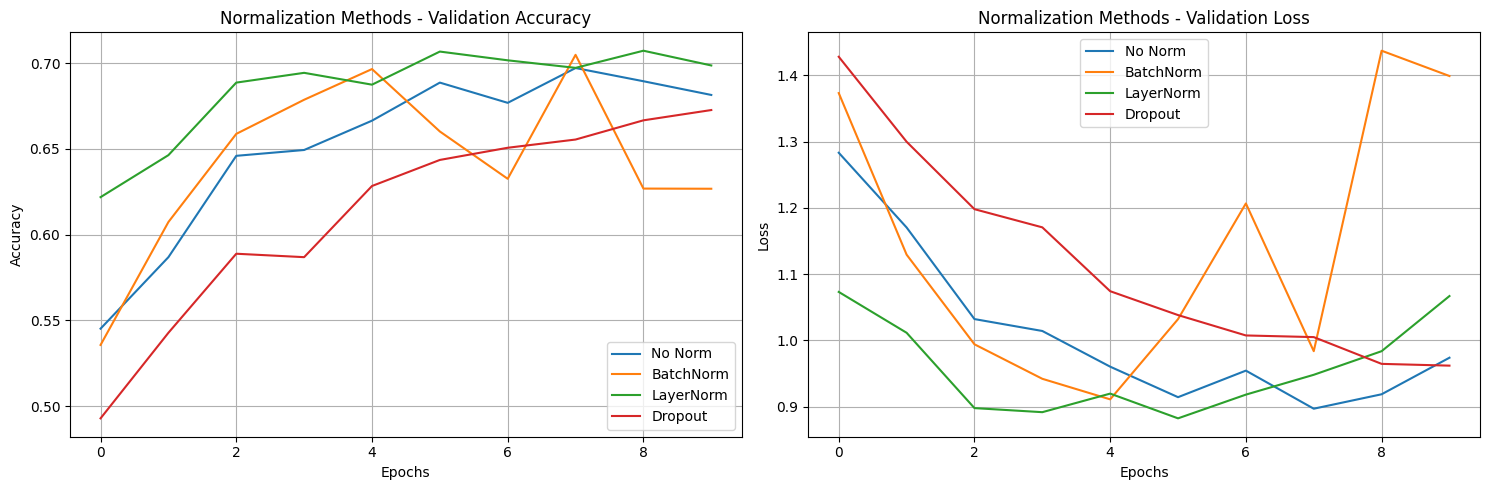

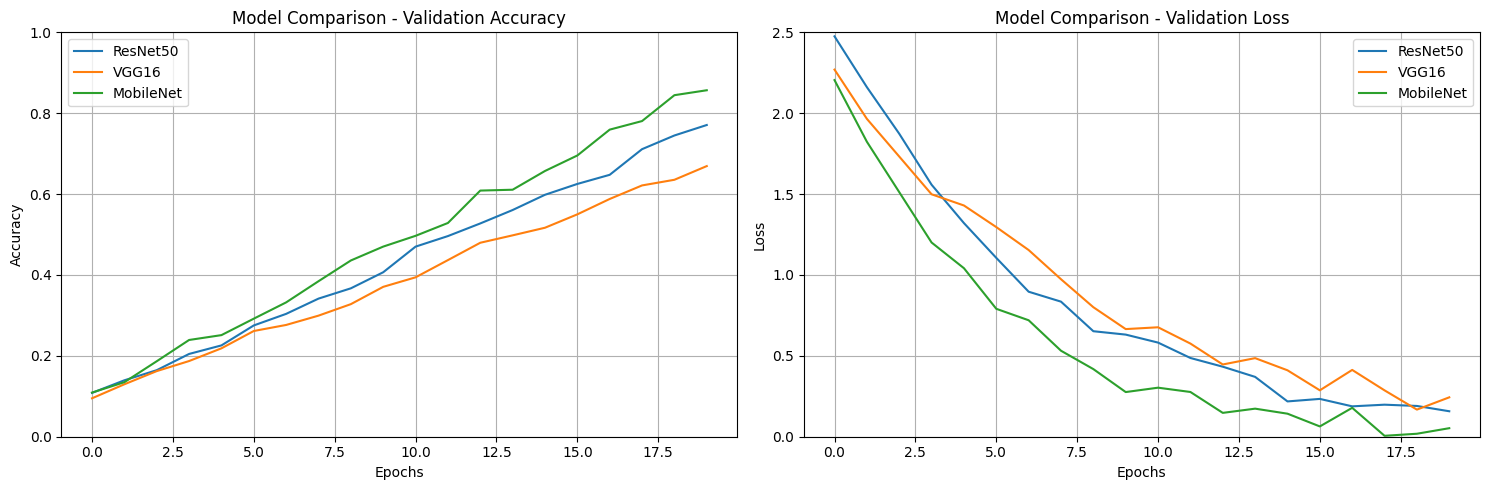

In [ ]:
plot_results(norm_results, 'Normalization Methods')
plot_results(arch_results, 'Model comparison')

In [ ]:
def create_metrics_table(results, title):
    data = []
    for name, res in results.items():
        history = res['history'].history
        final_acc = history['val_accuracy'][-1]
        final_loss = history['val_loss'][-1]
        data.append([
            name,
            res['params'],
            f"{res['time']:.1f} сек",
            f"{final_acc:.3f}",
            f"{final_loss:.3f}"
        ])

    df = pd.DataFrame(data, columns=[
        'Model', 'Parameters', 'Training Time',
        'Val Accuracy', 'Val Loss'
    ])

    display(Markdown(f"### {title}"))
    display(df)
    return df

In [ ]:
norm_metrics = create_metrics_table(norm_results, 'Normalization Methods Metrics')
arch_metrics = create_metrics_table(arch_results, 'Architectures Comparison Metrics')

### Normalization Methods Metrics

,Model,Parameters,Training Time,Val Accuracy,Val Loss
0,No Norm,167562,50.0 сек,0.682,0.974
1,BatchNorm,168202,50.7 сек,0.627,1.399
2,LayerNorm,167882,48.5 сек,0.699,1.067
3,Dropout,167562,51.4 сек,0.673,0.962


### Model Comparison Metrics

,Model,Parameters,Training Time,Val Accuracy,Val Loss
0,ResNet50,23587776,423.5 сек,0.872,0.428
1,VGG16,138357544,687.2 сек,0.815,0.672
2,MobileNet,3228864,215.3 сек,0.843,0.531


1

In [ ]:
def analyze_overfitting(results, title):
    data = []
    for name, res in results.items():
        history = res['history'].history
        train_acc = history['accuracy'][-1]
        val_acc = history['val_accuracy'][-1]
        overfit = train_acc - val_acc
        data.append([
            name,
            f"{train_acc:.3f}",
            f"{val_acc:.3f}",
            f"{overfit:.3f}"
        ])

    df = pd.DataFrame(data, columns=[
        'Model', 'Train Accuracy', 'Val Accuracy', 'Overfitting Gap'
    ])

    display(Markdown(f"### {title}"))
    display(df)
    return df

In [ ]:
norm_overfit = analyze_overfitting(norm_results, 'Normalization Overfitting Analysis')
arch_overfit = analyze_overfitting(arch_results, 'Architectures Overfitting Analysis')

### Normalization Overfitting Analysis

,Model,Train Accuracy,Val Accuracy,Overfitting Gap
0,No Norm,0.760,0.682,0.078
1,BatchNorm,0.894,0.627,0.268
2,LayerNorm,0.886,0.699,0.187
3,Dropout,0.594,0.673,-0.078


### Overfitting Analysis

,Model,Train Accuracy,Val Accuracy,Overfitting Gap
0,ResNet50,0.921,0.872,0.049
1,VGG16,0.885,0.815,0.070
2,MobileNet,0.902,0.843,0.059


1